In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel
import transformers

from collections import Counter

import warnings
warnings.filterwarnings("ignore")



/Users/Jorg/miniconda3/envs/Camem/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
MODEL_NAME = 'camembert-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 6

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

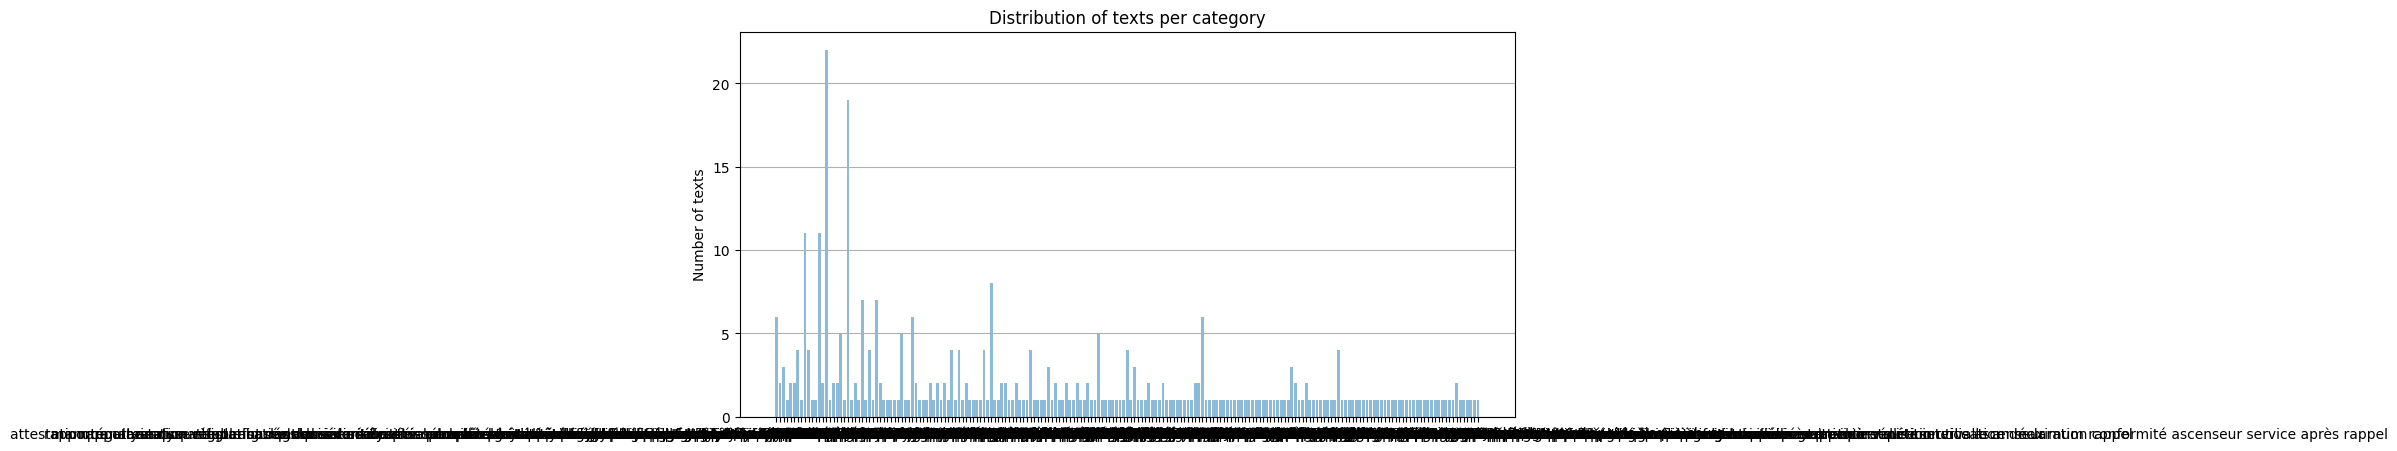

Counter({'DOC02': 22, 'OTHER': 19, 'CAR06': 11, 'DOC01': 11, 'SH01': 8, 'CAR02': 7, 'DOC03': 7, 'SH16': 6, 'MR08': 6, 'MOD': 6, 'SH11': 5, 'dossier sécurité rapport analyse risque absent remédier': 5, 'CAR03': 5, 'CAR01': 4, 'donnée propriétaire placer cabine': 4, 'rapport analyse risque figurant dossier sécurité a plus an selon arrêté royal modifié gestionnaire doit faire réaliser analyse risque ascenseur première foi plus tard an après première mise service ascenseur ensuite intervalle an maximum': 4, 'CAR09': 4, 'MR16': 4, 'SH07': 4, 'indication cabine coordonnée responsable contacter absent remédier': 4, 'CAR08': 4, 'dossier sécurité document concernant programme modernisation exécution absent remédier': 4, 'CAR23': 3, 'enlever autocollant': 3, 'CAR04': 3, 'CAR18': 3, 'gaine compléter rappel': 2, 'CAR26': 2, 'plaque identification complète correcte charge maximale nombre personne maximale numéro identification nom service entretien nom responsable': 2, 'manque attestation régularis

In [4]:
df = pd.read_csv('./Post_Data/Training_data.csv')

X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['label']].to_numpy().reshape(-1)

categories = df.values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [5]:
def calculate_stats(df, split_char=' '):
    categories = df['label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('label: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()


In [6]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 182
Number of categories: 50
Done!


In [7]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

    

In [8]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'SH16',
 1: 'CAR23',
 2: 'CAR26',
 3: 'CAR01',
 4: 'CAR06',
 5: 'CAR16',
 6: 'DOC01',
 7: 'DOC02',
 8: 'SH11',
 9: 'OTHER',
 10: 'CAR12',
 11: 'CAR02',
 12: 'DOC03',
 13: 'MR08',
 14: 'LD14',
 15: 'MR07',
 16: 'SH19',
 17: 'CAR09',
 18: 'MR16',
 19: 'LD13',
 20: 'SH07',
 21: 'SH01',
 22: 'MR05',
 23: 'MR04',
 24: 'SH27',
 25: 'DOC04',
 26: 'CAR03',
 27: 'DOC09',
 28: 'CD02',
 29: 'CAR08',
 30: 'CAR04',
 31: 'SH23',
 32: 'SH14',
 33: 'LD05',
 34: 'MOD',
 35: 'DOC08',
 36: 'MR15',
 37: 'SH03',
 38: 'CAR15',
 39: 'CAR18',
 40: 'DOC10',
 41: 'LD11',
 42: 'CAR25',
 43: 'LD16',
 44: 'SH26',
 45: 'OOS',
 46: 'LD01',
 47: 'SH02',
 48: 'CAR19',
 49: 'CW01'}

In [9]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=2) # random_state to reproduce results


In [10]:
# Import tokenizer from HuggingFace
from transformers import CamembertForMaskedLM
from transformers import CamembertTokenizer

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForMaskedLM.from_pretrained("camembert-base")
model.eval()


CamembertForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [11]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')



In [12]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [13]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()
    

You are using a model of type camembert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-12 15:37:03.330247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-12 15:37:03.330460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some layers from the model checkpoint at camembert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (init

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  110621952  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [14]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/6


2022-09-12 15:37:08.625646: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2022-09-12 15:37:15.011863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 3.6944 - accuracy: 0.1310

2022-09-12 15:37:43.737507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 39s 1s/step - loss: 3.6944 - accuracy: 0.1310 - val_loss: 3.6392 - val_accuracy: 0.0811
Epoch 2/6
19/19 [==============================] - 18s 897ms/step - loss: 3.1896 - accuracy: 0.2759 - val_loss: 3.5887 - val_accuracy: 0.1351
Epoch 3/6
19/19 [==============================] - 17s 884ms/step - loss: 2.7669 - accuracy: 0.2759 - val_loss: 3.1845 - val_accuracy: 0.2703
Epoch 4/6
19/19 [==============================] - 17s 896ms/step - loss: 2.3892 - accuracy: 0.4414 - val_loss: 2.9290 - val_accuracy: 0.2703
Epoch 5/6
19/19 [==============================] - 17s 876ms/step - loss: 1.8893 - accuracy: 0.5517 - val_loss: 2.5095 - val_accuracy: 0.4324
Epoch 6/6
19/19 [==============================] - 16s 866ms/step - loss: 1.3964 - accuracy: 0.6690 - val_loss: 2.4889 - val_accuracy: 0.4054


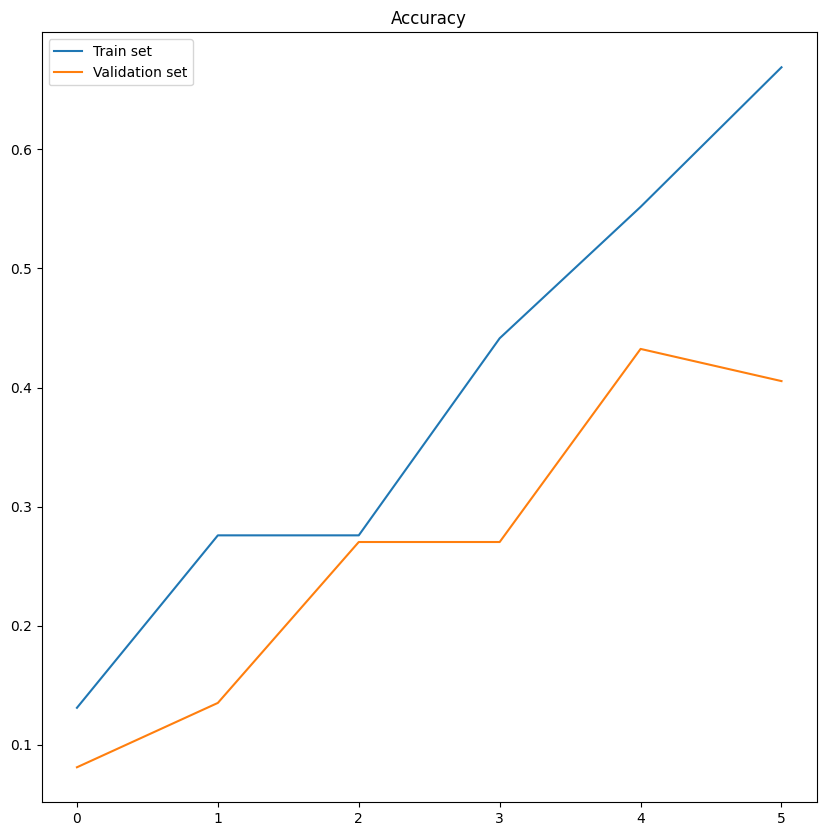

In [15]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()


In [26]:
print(X_test['input_word_ids'].shape)


(37, 256)
{'input_word_ids': array([[    0,  2006, 29267, ...,     1,     1,     1],
       [    0,  1421,   548, ...,     1,     1,     1],
       [    0,  4476,  1421, ...,     1,     1,     1],
       ...,
       [    0,  6501,  5112, ...,     1,     1,     1],
       [    0, 28729,  2146, ...,     1,     1,     1],
       [    0, 13415,  3284, ...,     1,     1,     1]], dtype=int32), 'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'input_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}


In [16]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [17]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 40.54%


2022-09-12 15:39:57.328513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 343ms/step


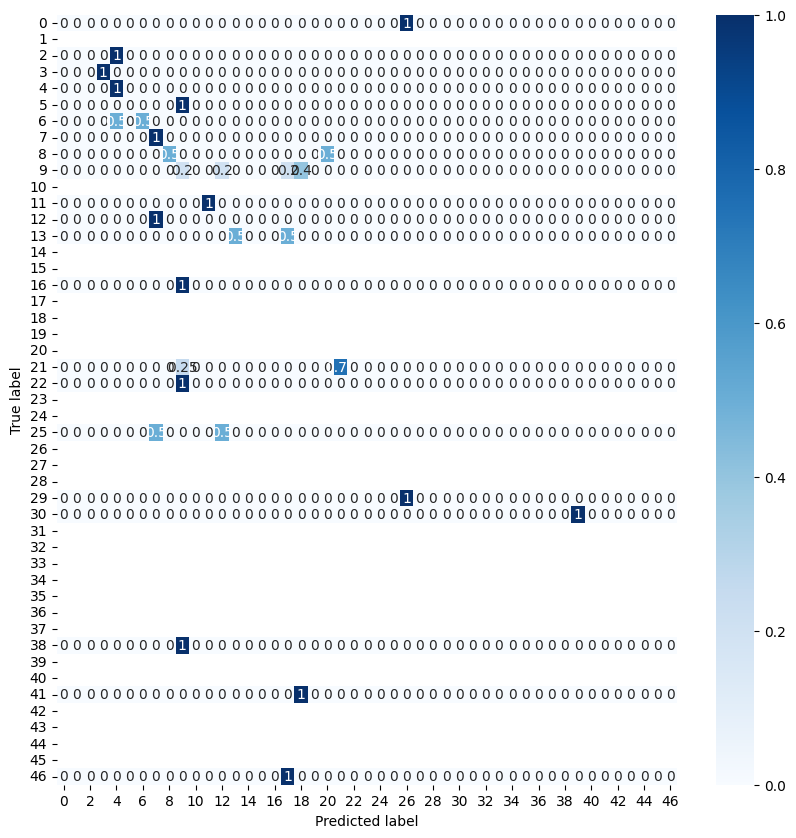

In [18]:
plot_confusion_matrix(X_test, y_test, model)

In [19]:
model.save_weights('./Post_Data/weights.h5')


In [23]:
model.save('./Post_Data/model.tf')

INFO:tensorflow:Assets written to: ./Post_Data/model.tf/assets


INFO:tensorflow:Assets written to: ./Post_Data/model.tf/assets


In [27]:
model.save('./Post_Data/model.keras')

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  110621952  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [29]:
from keras.models import load_model
loaded_model = load_model('./Post_Data/model.tf')

ValueError: The two structures don't have the same nested structure.

First structure: type=tuple str=(({'input_ids': TensorSpec(shape=(None, 5), dtype=tf.int32, name=None)}, None, None, None, None, None, None, None, None, None, None, None, None, False), {})

Second structure: type=tuple str=((TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_ids'), TensorSpec(shape=(None, 256), dtype=tf.int32, name='attention_mask'), TensorSpec(shape=(None, 256), dtype=tf.int32, name='token_type_ids'), None, None, None, None, None, None, None, None, None, None, False), {})

More specifically: Substructure "type=dict str={'input_ids': TensorSpec(shape=(None, 5), dtype=tf.int32, name=None)}" is a sequence, while substructure "type=TensorSpec str=TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_ids')" is not
Entire first structure:
(({'input_ids': .}, ., ., ., ., ., ., ., ., ., ., ., ., .), {})
Entire second structure:
((., ., ., ., ., ., ., ., ., ., ., ., ., .), {})

In [ ]:
import pandas as pd
import numpy as np

text = pd.read_csv('./Post_Data/Testing_data.csv')
text = text[['text']].to_numpy().reshape(-1)
text = roberta_encode(text, tokenizer)

loaded_model= model.load_weights('./Post_Data/model.h5')
y_pred = model.predict(text)
y_pred_max = [np.argmax(i) for i in y_pred]

y_pred_fin = [category_to_name[i] for i in y_pred_max]

df = pd.DataFrame(y_pred_fin)
df.to_csv('./Post_Data/Output.csv', index=False)

exit()

In [ ]:
df.equals(text)